In [1]:
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
! ls data/uniform

strong_fft_n=128000000_p=64_11077776 weak_fft_n=4096000000_p=512_11079232
strong_fft_n=128000000_p=64_11077778 weak_fft_n=4096000000_p=512_11079233
strong_fft_n=128000000_p=64_11079093 weak_fft_n=512000000_p=64_11077796
strong_fft_n=128000000_p=64_11079322 weak_fft_n=512000000_p=64_11077797
weak_fft_n=4096000000_p=512_11079231 weak_fft_n=512000000_p=64_11077800


In [106]:
! ls data/sphere/deeper_local_3 | grep weak

weak_fft_n=4096000000_p=512_points_per_rank=250000_distribution=sphere_11260141
weak_fft_n=4096000000_p=512_points_per_rank=500000_distribution=sphere_11260230


In [173]:
df0 = pd.read_csv('data/uniform/weak_fft_n=4096000000_p=512_11079232/weak_fft_n=4096000000_p=512_11079232.csv')
df1 = pd.read_csv('data/uniform/weak_fft_n=4096000000_p=512_11079231/weak_fft_n=4096000000_p=512_11079231.csv')
df2 = pd.read_csv('data/uniform/weak_fft_n=4096000000_p=512_11079233/weak_fft_n=4096000000_p=512_11079233.csv')


df3 = pd.read_csv('data/sphere/deeper_local_1/weak_fft_n=4096000000_p=512_points_per_rank=250000_distribution=sphere_11259998/weak_fft_n=4096000000_p=512_points_per_rank=250000_distribution=sphere_11259998.csv')
df4 = pd.read_csv('data/sphere/deeper_local_1/weak_fft_n=4096000000_p=512_points_per_rank=500000_distribution=sphere_11260013/weak_fft_n=4096000000_p=512_points_per_rank=500000_distribution=sphere_11260013.csv')
df5 = pd.read_csv('data/sphere/deeper_local_1/weak_fft_n=4096000000_p=512_points_per_rank=4000000_distribution=sphere_11260022/weak_fft_n=4096000000_p=512_points_per_rank=4000000_distribution=sphere_11260022.csv')


df3 = pd.read_csv('data/sphere/deeper_local_3/weak_fft_n=4096000000_p=512_points_per_rank=250000_distribution=sphere_11260141/weak_fft_n=4096000000_p=512_points_per_rank=250000_distribution=sphere_11260141.csv')
df4 = pd.read_csv('data/sphere/deeper_local_3/weak_fft_n=4096000000_p=512_points_per_rank=500000_distribution=sphere_11260230/weak_fft_n=4096000000_p=512_points_per_rank=500000_distribution=sphere_11260230.csv')


In [174]:
import seaborn as sns

def weak_scaling(dfs, names=None, title="Weak Scaling Performance", plot_err=True, stat='mean'):
    """
    Plots weak scaling results (runtime + efficiency) for one or more DataFrames.

    Parameters
    ----------
    dfs : list of pandas.DataFrame or pandas.DataFrame
        One or more DataFrames with columns including:
        ['experiment_id', 'runtime', 'p2m', 'm2l', 'm2m', 'l2l', 'source_tree', 'n_points', 'source_local_trees_per_rank']
    names : list of str, optional
        Names/labels for each DataFrame. Must be same length as dfs.
    title : str
        Figure title.
    """

    # Handle single DataFrame
    if not isinstance(dfs, (list, tuple)):
        dfs = [dfs]
    if names is None:
        names = [f"Run {i+1}" for i in range(len(dfs))]

    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax_runtime, ax_eff = axes

    markers = ['o', 's', '^', 'D', 'v', 'P', '*']
    colors = sns.color_palette("deep", len(dfs))

    for df, label, color, marker in zip(dfs, names, colors, markers):
        # Aggregate per experiment
        stats = df.groupby('experiment_id')[['runtime', 'p2m', 'm2l', 'm2m', 'l2l',
                                             'source_tree', 'n_points', 'source_local_trees_per_rank']]

        if stat == "mean":
            runtime = stats.mean()['runtime']
        elif stat == "median":
            runtime = stats.median()['runtime']
        else:
            raise ValueError("Only supports 'mean' or 'median'")
        
        runtime_err = stats.std()['runtime']
        n_ranks = stats.size()
        n_points = stats.mean()['n_points'] * n_ranks  # total DoFs = per-rank * ranks

        # Reference runtime
        T_ref = runtime.min()
        efficiency = (T_ref / runtime) * 100

        if plot_err:
            # Runtime plot
            ax_runtime.errorbar(
                n_points, runtime, yerr=runtime_err,
                fmt=marker+'-', color=color, capsize=4, label=label,
                linewidth=2, markersize=7
            )
        else:
            ax_runtime.plot(
                n_points, runtime, marker=marker,
                color=color, label=label,
                linewidth=2, markersize=7
            )

        

        # Efficiency plot
        ax_eff.plot(
            n_ranks, efficiency, marker=marker, linestyle='-', color=color,
            label=label, linewidth=2, markersize=7
        )

    # --- Runtime plot formatting ---
    ax_runtime.set_xscale('log')
    ax_runtime.set_yscale('log')
    ax_runtime.set_xlabel('Total Number of Points (DoFs)', fontsize=13)
    ax_runtime.set_ylabel('Runtime (ms)', fontsize=13)
    ax_runtime.set_title('Weak Scaling (Runtime)', fontsize=14)
    ax_runtime.grid(True, which="both", ls="--", lw=0.5)
    ax_runtime.legend(fontsize=11)

    # --- Efficiency plot formatting ---
    ax_eff.set_xscale('log', base=2)
    ax_eff.set_ylim(0, 110)
    ax_eff.set_xlabel('Number of Ranks', fontsize=13)
    ax_eff.set_ylabel('Parallel Efficiency (%)', fontsize=13)
    ax_eff.set_title('Parallel Efficiency', fontsize=14)
    ax_eff.grid(True, which="both", ls="--", lw=0.5)
    ax_eff.legend(fontsize=11)

    # --- Global figure adjustments ---
    fig.suptitle(title, fontsize=16, y=1.03)
    plt.tight_layout()
    plt.show()


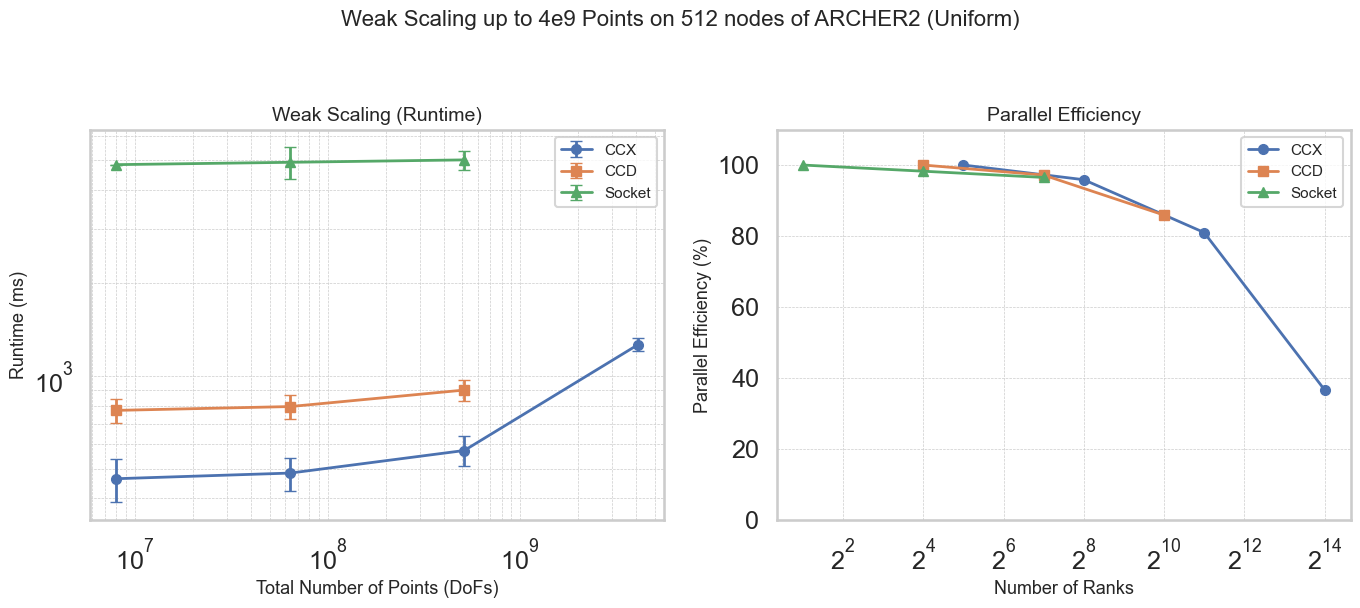

In [175]:
weak_scaling([df0, df1, df2], names=["CCX", "CCD", "Socket"], title="Weak Scaling up to 4e9 Points on 512 nodes of ARCHER2 (Uniform)")

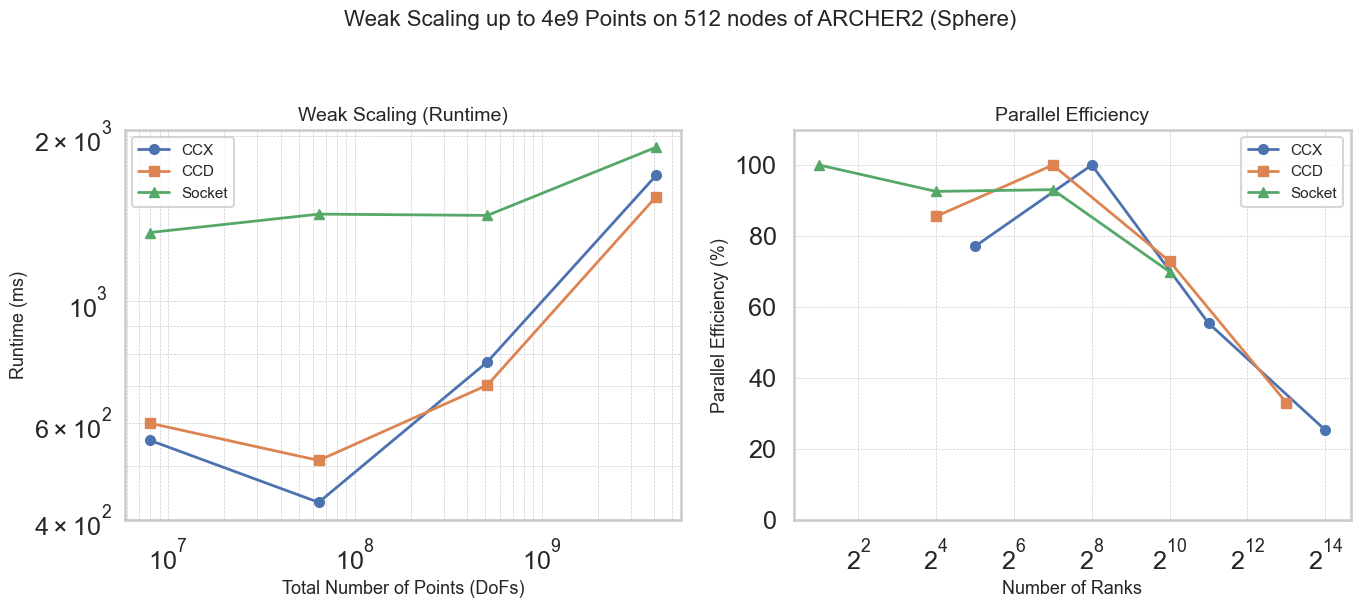

In [176]:
weak_scaling([df3, df4, df5], names=["CCX", "CCD", "Socket"], title="Weak Scaling up to 4e9 Points on 512 nodes of ARCHER2 (Sphere)", stat='mean', plot_err=False)

In [195]:
df4.groupby('experiment_id')['local_depth'].mean()

experiment_id
0    4.0
1    5.0
2    5.0
3    5.0
Name: local_depth, dtype: float64

In [196]:
df4.groupby('experiment_id')['m2l'].mean()

experiment_id
0    109.125000
1    219.585938
2    103.228516
3     41.056885
Name: m2l, dtype: float64

In [197]:
df4.groupby('experiment_id')['p2p'].mean()

experiment_id
0    472.625000
1    258.945312
2    473.274414
3    904.404175
Name: p2p, dtype: float64

In [193]:
df4.groupby('experiment_id')['p2p'].mean() + df4.groupby('experiment_id')['m2l'].mean()

experiment_id
0    581.75000
1    478.53125
2    576.50293
3    945.46106
dtype: float64